In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

#os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read a previously trained LocationModel
c2l_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
results_folder_allen = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_brain_allen/'
sp_results_folder = f'{c2l_results_folder}scvi/'
sc_results_folder = f'{c2l_results_folder}regression_model/'

run_name = 'v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_200alphatest'

sp_data_file = f'{sp_results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

# read a previously trained LocationModel
sp_results_folder_old = f'{c2l_results_folder}'
old_run_name = 'LocationModelLinearDependentWMultiExperiment_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'
sp_data_file = f'{sp_results_folder_old}{old_run_name}/sp_with_clusters.h5ad'
adata_vis_old = anndata.read(sp_data_file)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/v3_lr0002_Adam_signatures_c2l_Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_200alphatest/figures/'

In [3]:
adata_vis.obs['region_cluster'] = adata_vis_old.obs['region_cluster'][adata_vis.obs_names]

# annotate region clusters
region_annot = pd.read_csv(f'{sp_results_folder_old}{old_run_name}/20200904_regionAnnotation_copy.csv')
region_annot = region_annot.loc[~region_annot['region_04092020'].isna(),:]
region_annot.index = region_annot['region_04092020'].astype(int).astype(str)
region_annot['region_final'] = region_annot['region_final'].astype(int).astype(str)
region_annot.index.name = 'region_cluster'
region_annot = region_annot.reindex(index = list(adata_vis.obs['region_cluster']))
region_annot.index = adata_vis.obs_names

adata_vis.obs[region_annot.columns] = region_annot

adata_vis.obs[region_annot.columns].to_csv(f'{sp_results_folder}{run_name}/20200904_regionAnnotation_per_location.csv')

In [4]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y
    

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [5]:
# Define functions that compute per layer average abundance of each cell type & plot annotated scatterplot
def layer_distribution(slide, lay=None, layer_col='SSp_manual_layers', 
                       post_type='', sel_clust_col=adata_vis.uns['mod']['factor_names'],
                       summary_fun=np.mean, proportion_per_layer=False, 
                      layers=['L1', 'L23', 'L4', 'L5', 'L6']):
    
    # log-transform and save with nice names
    #slides[s].obs[sel_clust] = np.log10(slides[s].obs[sel_clust_col])
    infer_lay_df = slide.obs[sel_clust_col]
    sel_clust = sel_clust_col
    #infer_lay_df.columns = sel_clust

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in slide.obs[layer_col].unique():
        ind = slide.obs[layer_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = summary_fun(infer_lay_df.loc[ind, :], axis=0)
    
    infer_lay = infer_lay[layers]
    infer_lay.columns = layers
    infer_lay = infer_lay.loc[infer_lay.sum(1) > 0, :]
    if lay is not None:
        infer_lay = infer_lay.loc[lay.index, :]
    infer_lay = infer_lay.loc[np.sort(list(infer_lay.index)), :]
    
    # convert to proportions per layer
    if proportion_per_layer is True:
        infer_lay = infer_lay / infer_lay.sum(0)
    
    return infer_lay

def plot_hist2d(x, y, xlab, ylab, log=False, scatter_kwdargs:dict={}):
    
    corr = np.corrcoef(
        x.values.flatten(), 
        y.values.flatten())[0,1]
    corr_log10 = np.corrcoef(
        np.log10(x.values.flatten() + 1), 
        np.log10(y.values.flatten() + 1))[0,1]

    if log:
        x = np.log10(x.values.flatten() + 1)
        y = np.log10(y.values.flatten() + 1)
        
        xlab = xlab + ' (log10)'
        ylab = ylab + ' (log10)'
    else:
        x = x.values.flatten()
        y = y.values.flatten()

    #plt.hist2d(x, y, bins=35, norm=matplotlib.colors.LogNorm());
    plt.scatter(x, y, **scatter_kwdargs);
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.xlim(0);
    plt.ylim(0);
    plt.title(r'$R^2$: ' \
              + str(np.round(corr, 3))\
              #+ r', $R^2$ log: '+ str(np.round(corr_log10, 3))
             );

Trying to set attribute `.uns` of view, copying.
... storing 'region_final' as categorical
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical
... storing 'SSp_manual_layers' as categorical


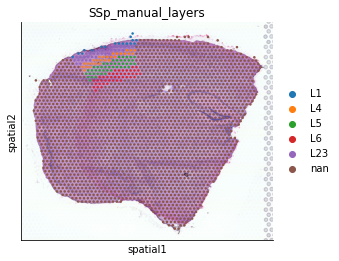

In [6]:
### load cortical layer annotations ###
# read in manual SSp cortical layer annotations
lay = pd.DataFrame()
for s in np.unique(adata_vis.obs['sample']):
    
    lay_file = results_folder_allen + 'manual_SSp_layers/SSp_ManLayerAnn_' \
                + str(s) + '.csv'
    lay_ = pd.read_csv(lay_file, index_col='Barcode')
    lay_.index = [str(s) + '_' + i for i in lay_.index]
    lay = pd.concat([lay, lay_])
    
adata_vis.obs['SSp_manual_layers'] = lay.reindex(index=adata_vis.obs_names) 

# plot to check that it loaded correctly
slide = select_slide(adata_vis, 'ST8059051')
sc.pl.spatial(slide, img_key = "hires", cmap='magma',
              color=['SSp_manual_layers'], size=1,
              gene_symbols='SYMBOL', ncols=1)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


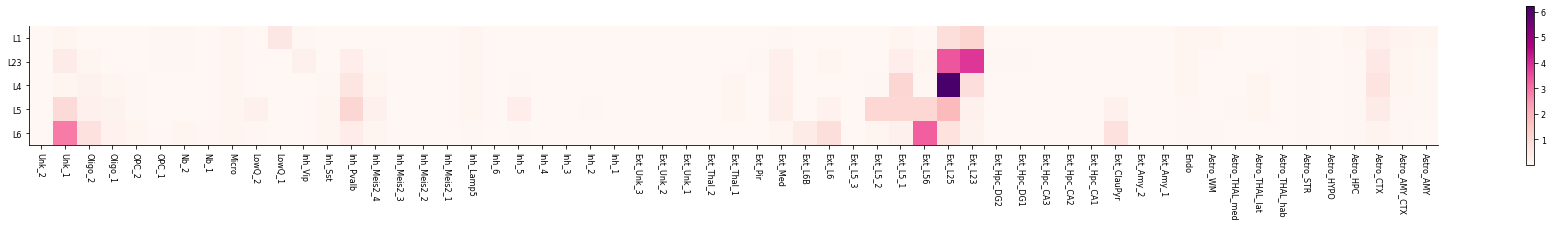

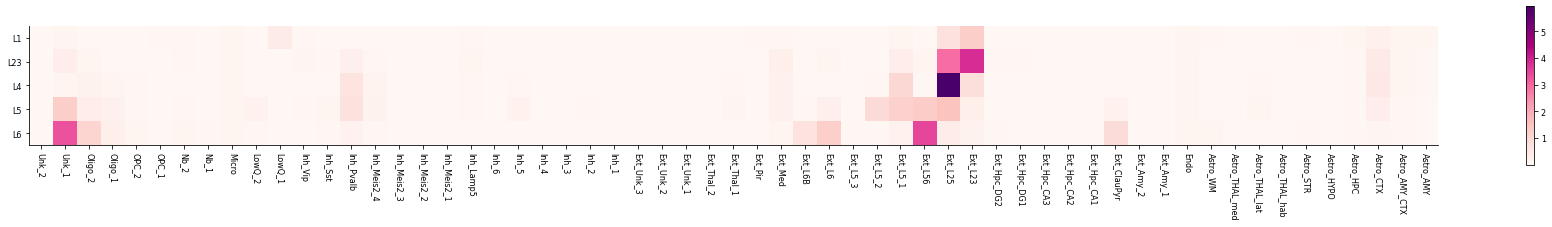

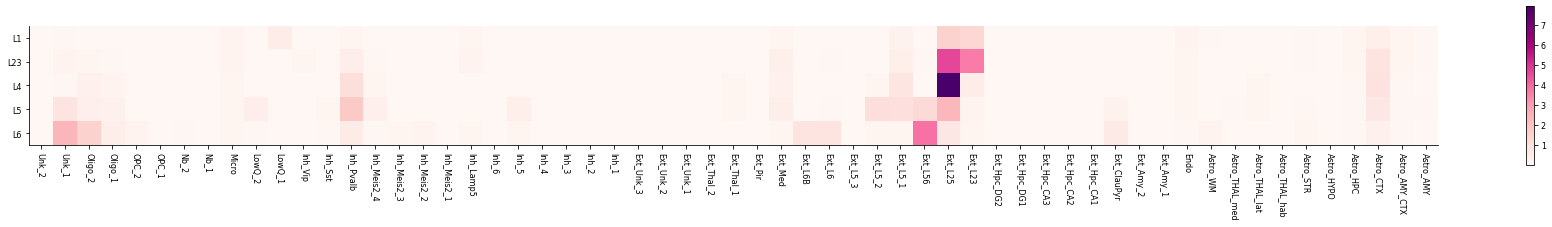

In [7]:
# Compute per layer abundances
infer_lay_ST8059048 = layer_distribution(select_slide(adata_vis, 'ST8059048').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059049 = layer_distribution(select_slide(adata_vis, 'ST8059049').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059051 = layer_distribution(select_slide(adata_vis, 'ST8059051').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059052 = layer_distribution(select_slide(adata_vis, 'ST8059052').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False)
infer_lay_ST8059050 = layer_distribution(select_slide(adata_vis, 'ST8059050').copy(), 
                                         summary_fun=np.mean, proportion_per_layer=False,
                                        layers=['L23', 'L4', 'L5', 'L6'])

# Plot per layer abundances of all cell types per section for supplementary materials
from cell2location.plt.plot_heatmap import clustermap
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 8}):
    clustermap(infer_lay_ST8059048.T, figure_size=(25, 3), 
               cmap='RdPu', log=False,
               cluster_rows=False, cluster_cols=False)
    plt.show()
    clustermap(infer_lay_ST8059049.T, figure_size=(25, 3), 
               cmap='RdPu', log=False,
               cluster_rows=False, cluster_cols=False)
    plt.show()
    clustermap(infer_lay_ST8059052.T, figure_size=(25, 3), 
               cmap='RdPu', log=False,
               cluster_rows=False, cluster_cols=False)
    plt.show()

In [8]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 7
# matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['savefig.dpi'] = 250

### Whole genes

In [9]:
samples = [infer_lay_ST8059051.T, infer_lay_ST8059049.T, infer_lay_ST8059048.T, infer_lay_ST8059052.T, infer_lay_ST8059050.T]
samples = [i.values.sum(axis=0)[:, np.newaxis] for i in samples]

sample_matrix = np.concatenate(samples, axis=1)
df = pd.DataFrame(sample_matrix, columns=['ST8059051', 'ST8059049', 'ST8059048', 'ST8059052', 'ST8059050'],
                  index=infer_lay_ST8059051.T.columns)

<Figure size 216x576 with 0 Axes>

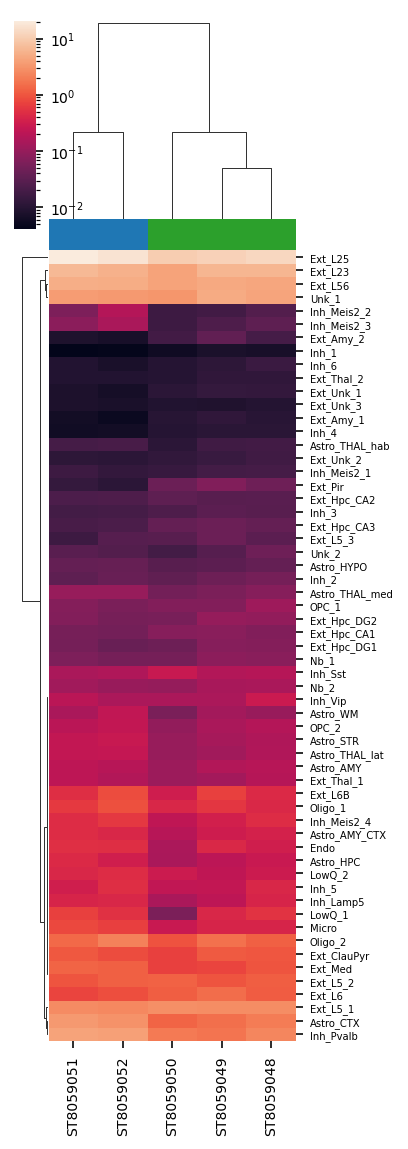

In [10]:
plt.figure(figsize=(3, 8))
col_colors = ['C0', 'C2', 'C2', 'C0', 'C2']
g = sns.clustermap(df, dendrogram_ratio=(.1, .2), col_colors=col_colors,
                   figsize=(3, 8), norm=matplotlib.colors.LogNorm())

g.ax_heatmap.set_yticks(np.arange(len(g.dendrogram_row.reordered_ind)) + 0.5)
g.ax_heatmap.set_yticklabels(infer_lay_ST8059051.T.columns[g.dendrogram_row.reordered_ind].values);
g.ax_heatmap.yaxis.set_tick_params(labelsize=5)

plt.savefig(f'{fig_path}FigS10/FigS10_without_layers.pdf', bbox_inches='tight')

###  Layers - mice

In [11]:
samples = [infer_lay_ST8059051.T, infer_lay_ST8059049.T, infer_lay_ST8059048.T, infer_lay_ST8059052.T, infer_lay_ST8059050.T]

In [12]:
pd.concat(samples)

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO,Astro_STR,Astro_THAL_hab,Astro_THAL_lat,Astro_THAL_med,Astro_WM,...,LowQ_2,Micro,Nb_1,Nb_2,OPC_1,OPC_2,Oligo_1,Oligo_2,Unk_1,Unk_2
L1,0.075335,0.181634,0.458213,0.229464,0.006208,0.090892,0.007105,0.016212,0.010288,0.086370,...,0.003240,0.257730,0.010929,0.039478,0.011968,0.003126,0.001415,0.003247,0.065970,0.005363
L23,0.057926,0.152816,1.061340,0.088874,0.006214,0.048713,0.003151,0.036867,0.017040,0.008640,...,0.006345,0.216195,0.008573,0.012701,0.010552,0.021720,0.045363,0.106093,0.101519,0.006821
L4,0.035577,0.061270,1.079242,0.048885,0.008726,0.024987,0.002731,0.088204,0.030706,0.007487,...,0.041518,0.101167,0.005016,0.008926,0.025217,0.043514,0.142185,0.250104,0.037394,0.004755
L5,0.033347,0.037603,0.624253,0.043379,0.011267,0.029068,0.003265,0.086949,0.034644,0.009925,...,0.316241,0.088821,0.008244,0.011525,0.013675,0.073023,0.164562,0.385966,0.701766,0.005108
L6,0.020044,0.040481,0.214600,0.034603,0.005670,0.044664,0.003119,0.016603,0.008762,0.035514,...,0.044192,0.139538,0.029547,0.053254,0.010132,0.063891,0.262712,0.668389,2.715140,0.008094
L1,0.067564,0.104576,0.213860,0.078692,0.006319,0.030762,0.005409,0.012731,0.007106,0.042213,...,0.002052,0.089467,0.007999,0.025525,0.025951,0.004636,0.009826,0.017744,0.104669,0.005856
L23,0.035101,0.080936,0.449394,0.042325,0.004849,0.022646,0.002598,0.015425,0.009100,0.009823,...,0.004348,0.103997,0.011142,0.025644,0.017149,0.003442,0.016822,0.053630,0.321396,0.004425
L4,0.026988,0.051045,0.486657,0.032915,0.007650,0.018120,0.002321,0.041877,0.018717,0.006197,...,0.007788,0.065425,0.006871,0.008849,0.004971,0.025333,0.094724,0.154891,0.050220,0.002997
L5,0.023587,0.036868,0.310917,0.031326,0.008538,0.023441,0.002733,0.047089,0.019508,0.011624,...,0.179415,0.065335,0.014384,0.024969,0.007308,0.036355,0.192558,0.308103,1.236712,0.005357
L6,0.018910,0.035851,0.088522,0.026987,0.004775,0.042892,0.004410,0.008296,0.004951,0.060349,...,0.030424,0.054216,0.042899,0.056967,0.012800,0.075901,0.265547,1.071866,3.277678,0.009207


In [13]:
# sample_names = ['ST8059051_', 'ST8059049_', 'ST8059048_', 'ST8059052_', 'ST8059050_']
sample_names = ['mouse_2_sample_4_', 'mouse_1_sample_1_', 'mouse_1_sample_2_', 'mouse_2_sample_5_', 'mouse_1_sample_3_']
new_samples = []

colors_dict = {i:f'C{n}'for n, i in enumerate(['L1', 'L23', 'L4', 'L5', 'L6'])}
layer_colors = pd.Series(pd.concat(samples).index).map(colors_dict).values

C1 = 'C6'
C2 = 'C7'
mouse_colors = [*[C2]*5, *[C1]*5, *[C1]*5, *[C2]*5, *[C1]*4]

sample_colors = [*['xkcd:deep orange']*5, *['xkcd:medium grey']*5, *['xkcd:light grey']*5, *['xkcd:bright orange']*5, *['xkcd:grey']*4]


for df, name in zip(samples, sample_names):
    new_samples.append(df.T.add_prefix(name).T)
    
df = pd.concat(new_samples).T

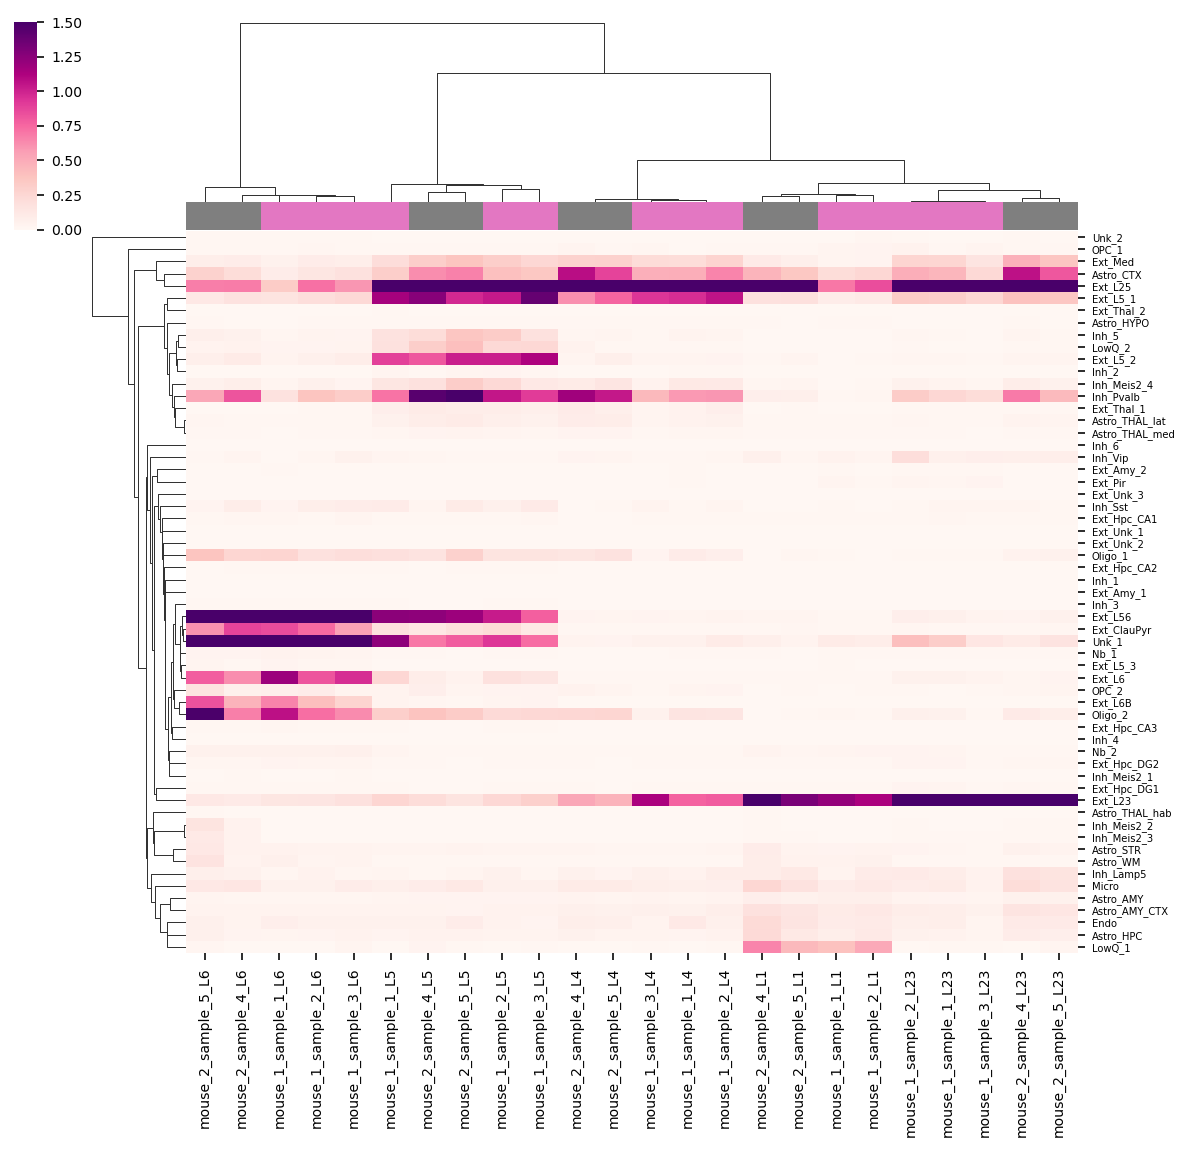

In [27]:
g = sns.clustermap(df, dendrogram_ratio=(.1, .2),
                   figsize=(8, 8), vmin=0, vmax=1.5,#norm=matplotlib.colors.LogNorm(),
                   cbar_pos=(-0.05, 0.8, 0.02, 0.18),
                   method='single',
                   col_colors=mouse_colors,
                   metric="correlation",
                   cmap='RdPu')

g.ax_heatmap.set_yticks(np.arange(len(g.dendrogram_row.reordered_ind)) + 0.5)
g.ax_heatmap.set_yticklabels(infer_lay_ST8059051.T.columns[g.dendrogram_row.reordered_ind].values);
g.ax_heatmap.yaxis.set_tick_params(labelsize=5)

plt.savefig(f'{fig_path}FigS10/FigS10_mouse_colors.pdf', bbox_inches='tight')

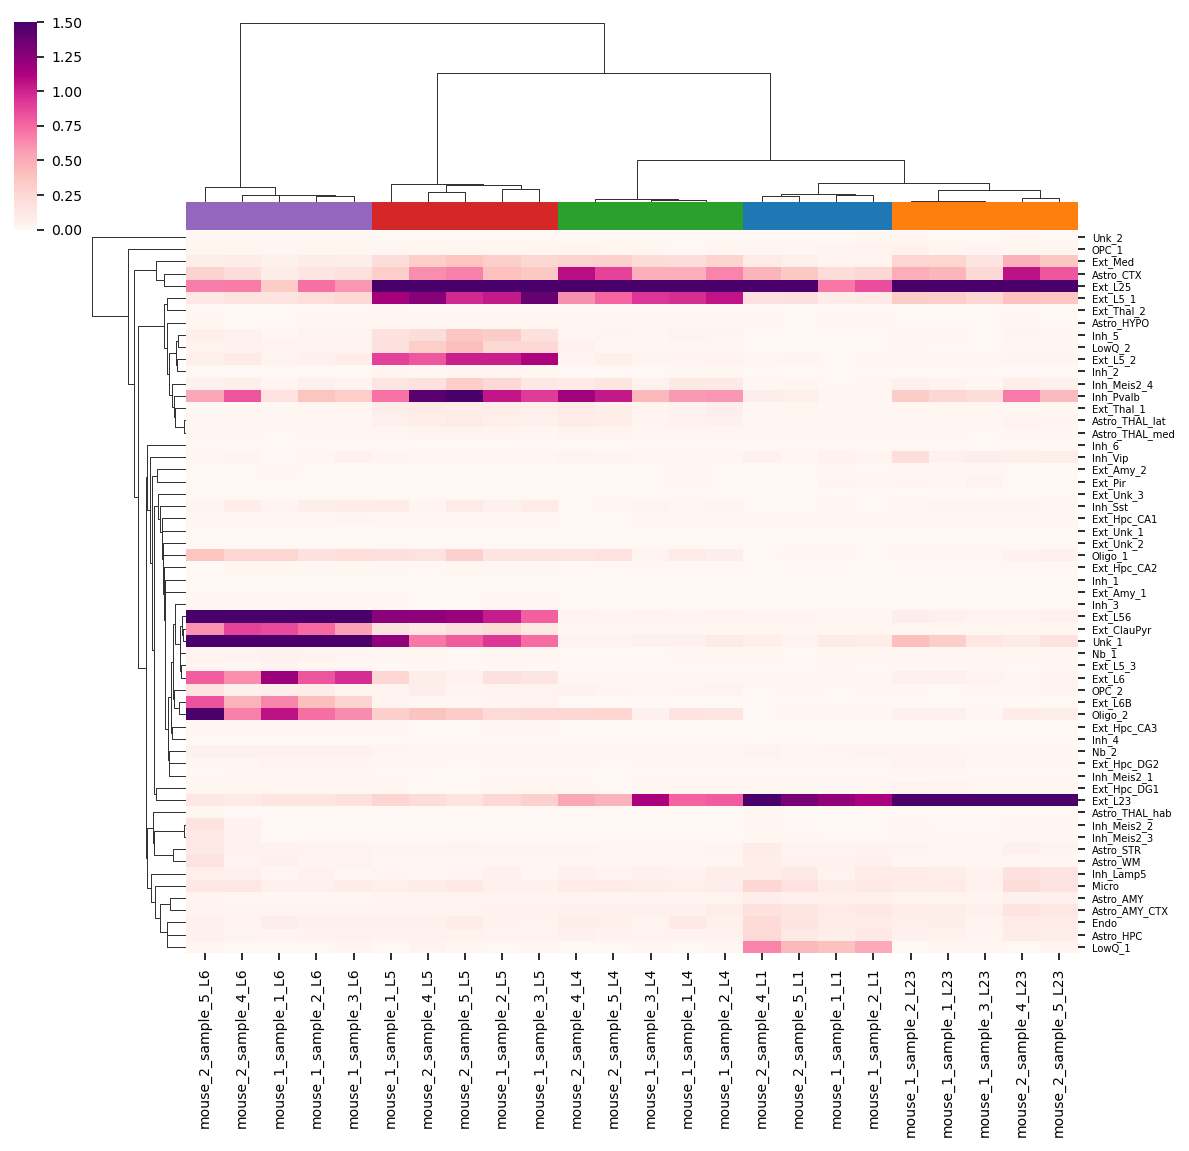

In [28]:
g = sns.clustermap(df, dendrogram_ratio=(.1, .2),
                   figsize=(8, 8), vmin=0, vmax=1.5,#norm=matplotlib.colors.LogNorm(),
                   cbar_pos=(-0.05, 0.8, 0.02, 0.18),
                   method='single',
                   col_colors=layer_colors,
                   metric="correlation",
                   cmap='RdPu')

g.ax_heatmap.set_yticks(np.arange(len(g.dendrogram_row.reordered_ind)) + 0.5)
g.ax_heatmap.set_yticklabels(infer_lay_ST8059051.T.columns[g.dendrogram_row.reordered_ind].values);
g.ax_heatmap.yaxis.set_tick_params(labelsize=5)

plt.savefig(f'{fig_path}FigS10/FigS10_layer_colors.pdf', bbox_inches='tight')

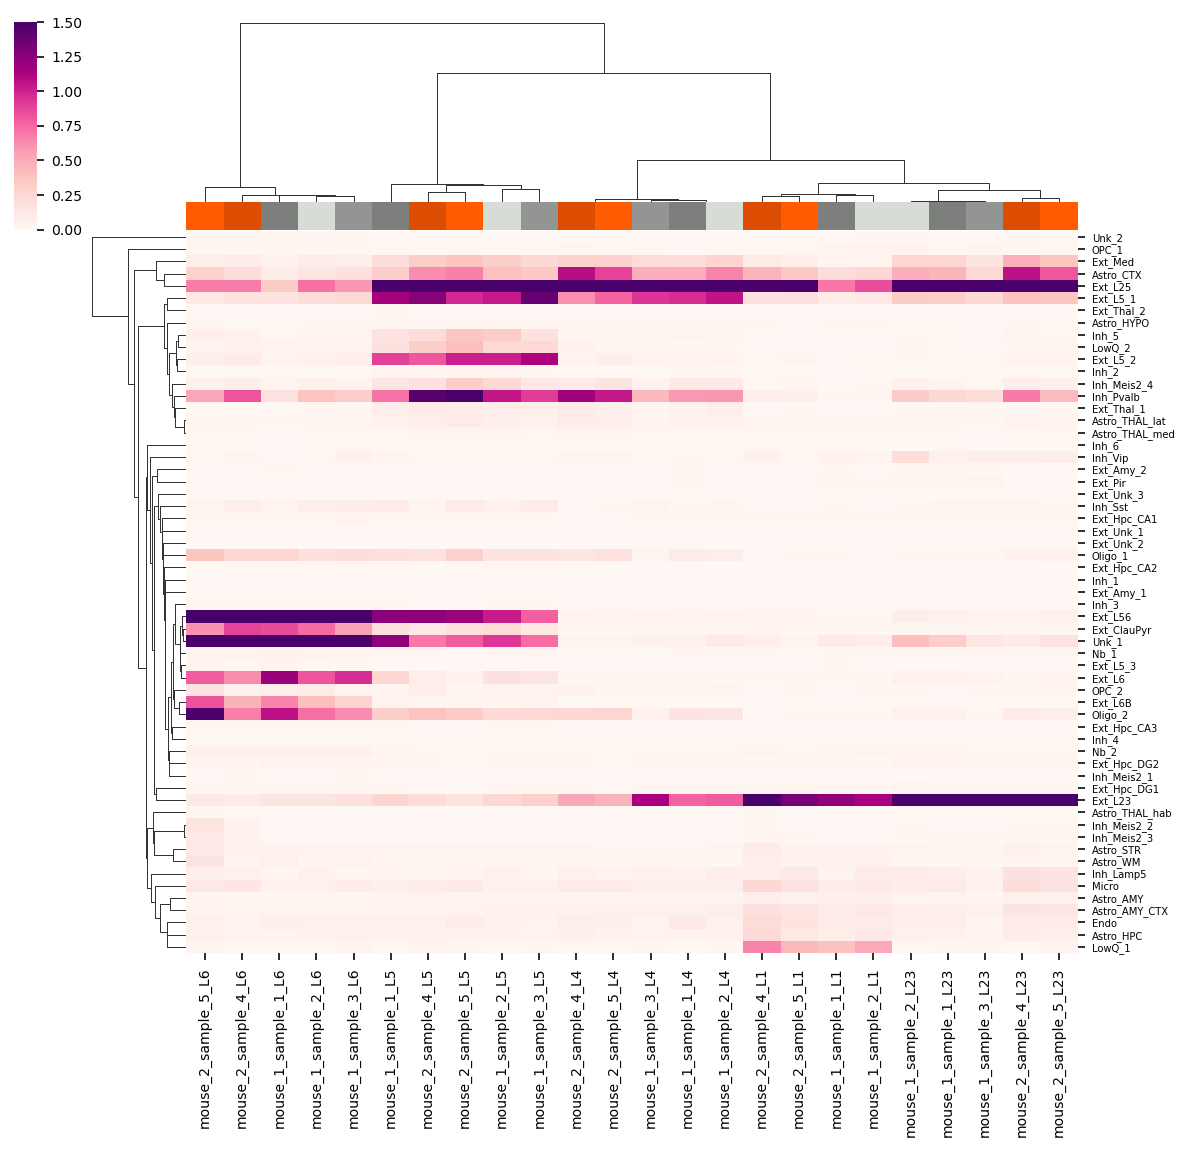

In [29]:
g = sns.clustermap(df, dendrogram_ratio=(.1, .2),
                   figsize=(8, 8), vmin=0, vmax=1.5,#norm=matplotlib.colors.LogNorm(),
                   cbar_pos=(-0.05, 0.8, 0.02, 0.18),
                   method='single',
                   col_colors=sample_colors,
                   metric="correlation",
                   cmap='RdPu')

g.ax_heatmap.set_yticks(np.arange(len(g.dendrogram_row.reordered_ind)) + 0.5)
g.ax_heatmap.set_yticklabels(infer_lay_ST8059051.T.columns[g.dendrogram_row.reordered_ind].values);
g.ax_heatmap.yaxis.set_tick_params(labelsize=5)

plt.savefig(f'{fig_path}FigS10/FigS10_sample_colors.pdf', bbox_inches='tight')

In [17]:
def plot_patch(labels, colors):
    patches = []
    for i in colors:
        patch, = plt.plot([], "s", c=i, markeredgewidth=3, markersize=7.5)
        patches.append(patch)
    plt.legend(patches, labels, frameon=False)

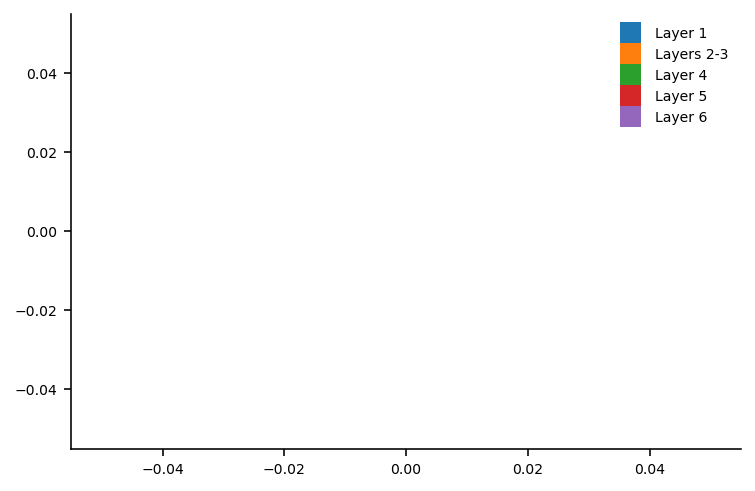

In [18]:
layer_legend_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
layer_legend_labels = ['Layer 1', 'Layers 2-3', 'Layer 4', 'Layer 5', 'Layer 6']
plot_patch(layer_legend_labels, layer_legend_colors)
plt.savefig(f'{fig_path}FigS10/FigS10_layer_colorbar.pdf', bbox_inches='tight')

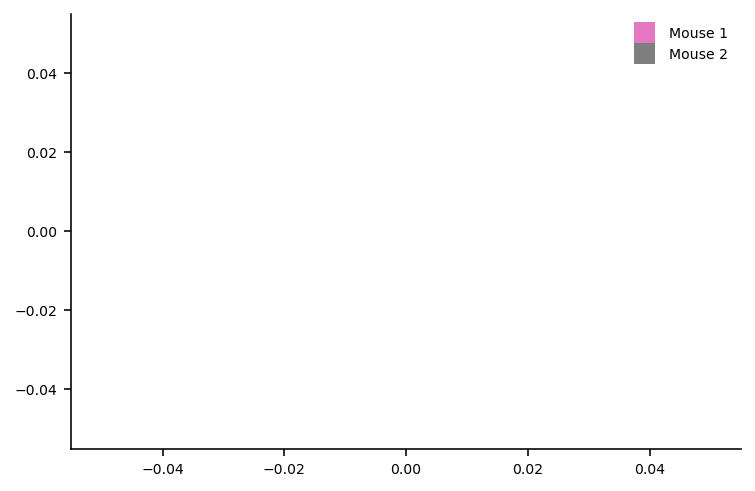

In [19]:
mouse_legend_colors = ['C6', 'C7']
mouse_legend_labels = ['Mouse 1', 'Mouse 2']
plot_patch(mouse_legend_labels, mouse_legend_colors)
plt.savefig(f'{fig_path}FigS10/FigS10_mouse_colorbar.pdf', bbox_inches='tight')

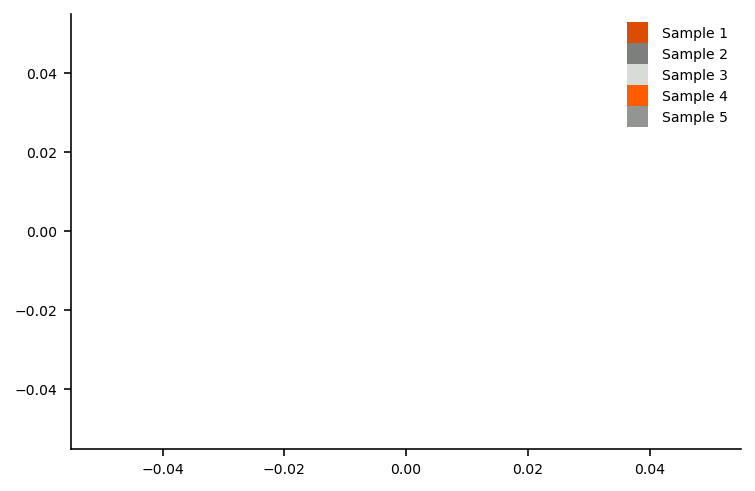

In [20]:
sample_legend_colors = ['xkcd:deep orange', 'xkcd:medium grey', 'xkcd:light grey', 'xkcd:bright orange', 'xkcd:grey']
sample_legend_labels = [f'Sample {i}' for i in range(1, 6)]
plot_patch(sample_legend_labels, sample_legend_colors)
plt.savefig(f'{fig_path}FigS10/FigS10_sample_colorbar.pdf', bbox_inches='tight')